**Marfa Zakirova, B06-906a**

## Lab 2
### Part 1. NN from scratch and MNIST warmup (1 point)
__This part is connected with assignment0_05, you will need to finish it firts. If it is not finished yet, you can work on the next parts.__


Please, go to the `week0_07` directory and fill the `main_notebook.ipynb`. Then hand in the completed notebook.

If you already done that (e.g. while working on assignment0_05), there is small update in there (which requires you to achieve same results with PyTorch network). Update the notebook or read the notebook in the web version.

## Practice: Basic Artificial Neural Networks
Credits: this notebook belongs to [Practical DL](https://docs.google.com/forms/d/e/1FAIpQLScvrVtuwrHSlxWqHnLt1V-_7h2eON_mlRR6MUb3xEe5x9LuoA/viewform?usp=sf_link) course by Yandex School of Data Analysis.

We will start working with neural networks on the practice session. Your homework will be to finish the implementation of the layers.

Our goal is simple, yet an actual implementation may take some time :). We are going to write an Artificial Neural Network (almost) from scratch. The software design was heavily inspired by [PyTorch](http://pytorch.org) which is the main framework of our course 

Speaking about the homework (once again, it will be really similar to this seminar), it requires sending **multiple** files, please do not forget to include all the files when sending to TA. The list of files:
- This notebook
- modules.ipynb with all blocks implemented (except maybe `Conv2d` and `MaxPool2d` layers implementation which are part of 'advanced' version of this homework)

In [47]:
%matplotlib inline
from time import time, sleep
import numpy as np
import matplotlib.pyplot as plt
from IPython import display
from tqdm import tqdm

# Framework

Implement everything in `modules.ipynb`. Read all the comments thoughtfully to ease the pain. Please try not to change the prototypes.

Do not forget, that each module should return **AND** store `output` and `gradInput`.

The typical assumption is that `module.backward` is always executed after `module.forward`,
so `output` is stored, this would be useful for `SoftMax`. 

### Tech note
Prefer using `np.multiply`, `np.add`, `np.divide`, `np.subtract` instead of `*`,`+`,`/`,`-` for better memory handling.

Example: suppose you allocated a variable 

```
a = np.zeros(...)
```
So, instead of
```
a = b + c  # will be reallocated, GC needed to free
``` 
You can use: 
```
np.add(b,c,out = a) # puts result in `a`
```

In [48]:
# (re-)load layers
%run modules1.ipynb

# Toy example

Use this example to debug your code, start with logistic regression and then test other layers. You do not need to change anything here. This code is provided for you to test the layers. Also it is easy to use this code in MNIST task.

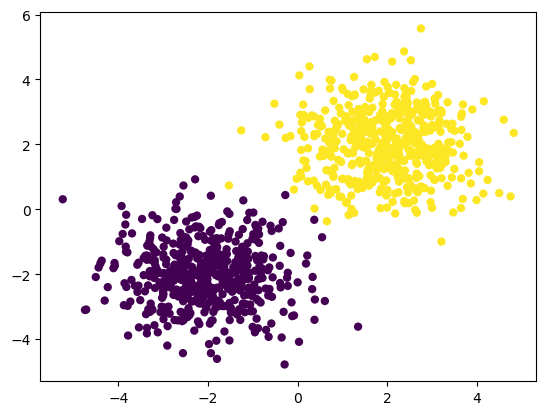

In [49]:
# Generate some data
N = 500

X1 = np.random.randn(N,2) + np.array([2,2])
X2 = np.random.randn(N,2) + np.array([-2,-2])

Y = np.concatenate([np.ones(N),np.zeros(N)])[:,None]
Y = np.hstack([Y, 1-Y])

X = np.vstack([X1,X2])
plt.scatter(X[:,0],X[:,1], c = Y[:,0], edgecolors= 'none')

Define a **logistic regression** for debugging. 

In [50]:
net = Sequential()
net.add(Linear(2, 2))
net.add(LogSoftMax())

criterion = ClassNLLCriterion()

print(net)

# # Test something like that then 

# net = Sequential()
# net.add(Linear(2, 4))
# net.add(ReLU())
# net.add(Linear(4, 2))
# net.add(LogSoftMax())

Linear 2 -> 2
LogSoftMax



Start with batch_size = 1000 to make sure every step lowers the loss, then try stochastic version.

In [51]:
# Iptimizer params
optimizer_config = {'learning_rate' : 1e-1, 'momentum': 0.9}
optimizer_state = {}

# Looping params
n_epoch = 20
batch_size = 128

In [148]:
# batch generator
def get_batches(dataset, batch_size):
    X, Y = dataset
    n_samples = X.shape[0]
        
    # Shuffle at the start of epoch
    indices = np.arange(n_samples)
    np.random.shuffle(indices)  # return none
    
    for start in range(0, n_samples, batch_size):
        end = min(start + batch_size, n_samples)
        
        batch_idx = indices[start:end]
    
        yield X[batch_idx], Y[batch_idx]

### Train

Basic training loop. Examine it.

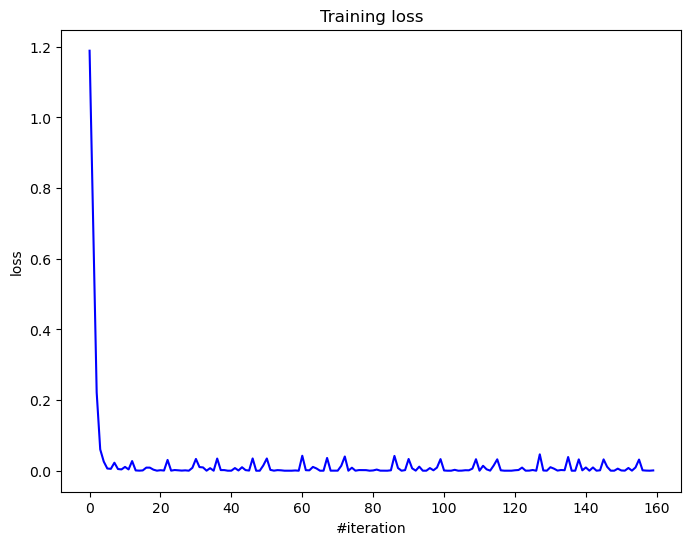

Current loss: 0.000839


In [53]:
loss_history = []

for i in range(n_epoch):
    for x_batch, y_batch in get_batches((X, Y), batch_size):
        
        net.zeroGradParameters()
        
        # Forward
        predictions = net.forward(x_batch)
        loss = criterion.forward(predictions, y_batch)
    
        # Backward
        dp = criterion.backward(predictions, y_batch)
        net.backward(x_batch, dp)
        
        # Update weights
        sgd_momentum(net.getParameters(), 
                     net.getGradParameters(), 
                     optimizer_config,
                     optimizer_state)      
        
        loss_history.append(loss)

    # Visualize
    display.clear_output(wait=True)
    plt.figure(figsize=(8, 6))
        
    plt.title("Training loss")
    plt.xlabel("#iteration")
    plt.ylabel("loss")
    plt.plot(loss_history, 'b')
    plt.show()
    
    print('Current loss: %f' % loss)    

# Digit classification 

We are using old good [MNIST](http://yann.lecun.com/exdb/mnist/) as our dataset.

In [126]:
import mnist
X_train, y_train, X_val, y_val, X_test, y_test = mnist.load_dataset()

In [127]:
print(X_train.shape) # before

X_train = X_train.reshape(X_train.shape[0], X_train.shape[1] * X_train.shape[2])
X_val = X_val.reshape(X_val.shape[0], X_val.shape[1] * X_val.shape[2])
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1] * X_test.shape[2])

X_train.shape

(50000, 28, 28)


(50000, 784)

One-hot encode the labels first.

In [128]:
# Your code goes here. ################################################
def one_hot_encode(n_classes, y):
    y_one_hot = np.zeros((len(y), n_classes), dtype=float)
    y_one_hot[np.arange(len(y)), y.astype(int)] = 1 
    return y_one_hot

n_classes = len(np.unique(y_test))

y_test = one_hot_encode(n_classes, y_test)
y_train = one_hot_encode(n_classes, y_train)
y_val = one_hot_encode(n_classes, y_val)
y_train.shape

(50000, 10)

- **Compare** `ReLU`, `ELU`, `LeakyReLU`, `SoftPlus` activation functions. 
You would better pick the best optimizer params for each of them, but it is overkill for now. Use an architecture of your choice for the comparison.
- **Try** inserting `BatchNormalization` (folowed by `ChannelwiseScaling`) between `Linear` module and activation functions.
- Plot the losses both from activation functions comparison and `BatchNormalization` comparison on one plot. Please find a scale (log?) when the lines are distinguishable, do not forget about naming the axes, the plot should be goodlooking.
- Plot the losses for two networks: one trained by momentum_sgd, another one trained by Adam. Which one performs better?
- Hint: good logloss for MNIST should be around 0.5. 

In [102]:
optimizer_conf = {'learning_rate' : 1e-2, 'momentum': 0.9}

def loss_train_net(net, X, Y, optimizer, optimizer_config = optimizer_conf, batch_size = 128, n_epoch = 5, criterion = ClassNLLCriterion()):
    iteration_loss_history = []
    optimizer_state = {}
    
    for i in tqdm(np.arange(n_epoch)):
        for x_batch, y_batch in get_batches((X, Y), batch_size):
        
            net.zeroGradParameters()
        
        # Forward
            predictions = net.forward(x_batch)
            loss = criterion.forward(predictions, y_batch)
    
        # Backward
            dp = criterion.backward(predictions, y_batch)
            net.backward(x_batch, dp)
        
        # Update weights
            optimizer(net.getParameters(), 
                         net.getGradParameters(), 
                         optimizer_config,
                         optimizer_state)      
        
            iteration_loss_history.append(loss)
            
    return iteration_loss_history

def visualisation_train_val(loss, loss_bn, activation_func, epoch = False):
    """ 
    Plot process of net education via epoch and iteration loss values.
    {epoch/iter}_loss_bn - {epoch/iteration} loss values of net with batchnorm
    {epoch/iter}_loss - without batchnorm
    if epoch: provided loss is for epochs
    """
    if epoch:
        axes_x = '# epoch'
    else:
        axes_x = '# iteration'


    print(f'Min loss value: {np.round(min(loss),5)}') 
    print(f'Min loss value with BN: {np.round(min(loss_bn),5)}') 

    plt.figure(figsize=(10,7))
    plt.plot(loss, label = activation_func, color = 'm')
    plt.plot(loss_bn, label = activation_func + ' BN', color = 'c')
    plt.xlabel(axes_x)
    plt.ylabel('loss value')
    plt.legend()
    plt.title('Training loss ' + activation_func +' with \ without BN')
    plt.show()

def show_difference(loss_bn_sgd, loss_adam, func_name):
    plt.figure(figsize=(10,7))
    plt.plot(loss_bn_sgd, label = func_name + ' BN SGD', color = 'b')
    plt.plot(loss_adam, label = func_name + ' Adam', color = 'g')
    plt.xlabel('# iteration')
    plt.ylabel('loss value')
    plt.legend()
    plt.title('Training loss '+ func_name +' SGD / Adam')
    plt.show()

In [80]:
def net_creation(activation_func, batch_norm_flag = False):
    global n_classes

    if batch_norm_flag:
        net = Sequential()
        net.add(Linear(784, 324))  # like 18*18 image
        net.add(BatchNormalization())
        net.add(ChannelwiseScaling(324))
        net.add(activation_func)
        net.add(Linear(324, 100)) # 10*10
        net.add(BatchNormalization())
        net.add(ChannelwiseScaling(100))
        net.add(activation_func)
        net.add(Linear(100, n_classes))
        net.add(LogSoftMax())
    else:
        net = Sequential()
        net.add(Linear(784, 500))
        net.add(activation_func)
        net.add(Linear(500, 100))
        net.add(activation_func)
        net.add(Linear(100, n_classes))
        net.add(LogSoftMax())

    print(net)
    return net


## Net with ReLU activation function
### SGD

Linear 784 -> 500
ReLU
Linear 500 -> 100
ReLU
Linear 100 -> 10
LogSoftMax

Linear 784 -> 324
BatchNormalization
ChannelwiseScaling
ReLU
Linear 324 -> 100
BatchNormalization
ChannelwiseScaling
ReLU
Linear 100 -> 10
LogSoftMax



100%|██████████| 5/5 [03:39<00:00, 43.90s/it]


Min loss value: 0.05337
Min loss value with BN: 0.00953


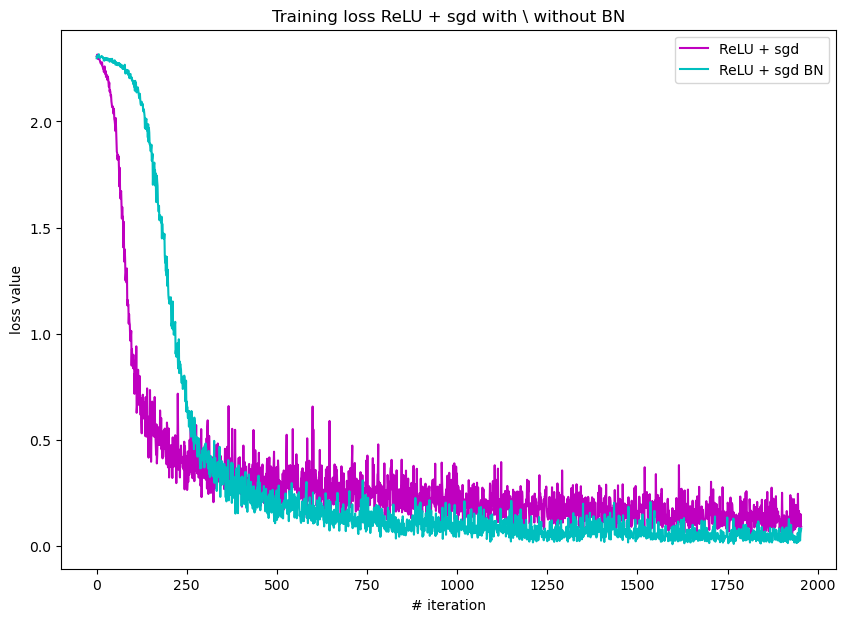

In [100]:
net_ReLU = net_creation(ReLU())
net_ReLU_bn = net_creation(ReLU(), batch_norm_flag= True)

iter_relu_loss_sgd = loss_train_net(net_ReLU, X_train, y_train, sgd_momentum)
iter_relu_loss_bn_sgd = loss_train_net(net_ReLU_bn, X_train, y_train, sgd_momentum)

visualisation_train_val(iter_relu_loss_sgd, iter_relu_loss_bn_sgd, 'ReLU + sgd')

### Adam

Linear 784 -> 500
ReLU
Linear 500 -> 100
ReLU
Linear 100 -> 10
LogSoftMax

Linear 784 -> 324
BatchNormalization
ChannelwiseScaling
ReLU
Linear 324 -> 100
BatchNormalization
ChannelwiseScaling
ReLU
Linear 100 -> 10
LogSoftMax



100%|██████████| 5/5 [03:27<00:00, 41.52s/it]


Min loss value: 0.00535
Min loss value with BN: 0.00283


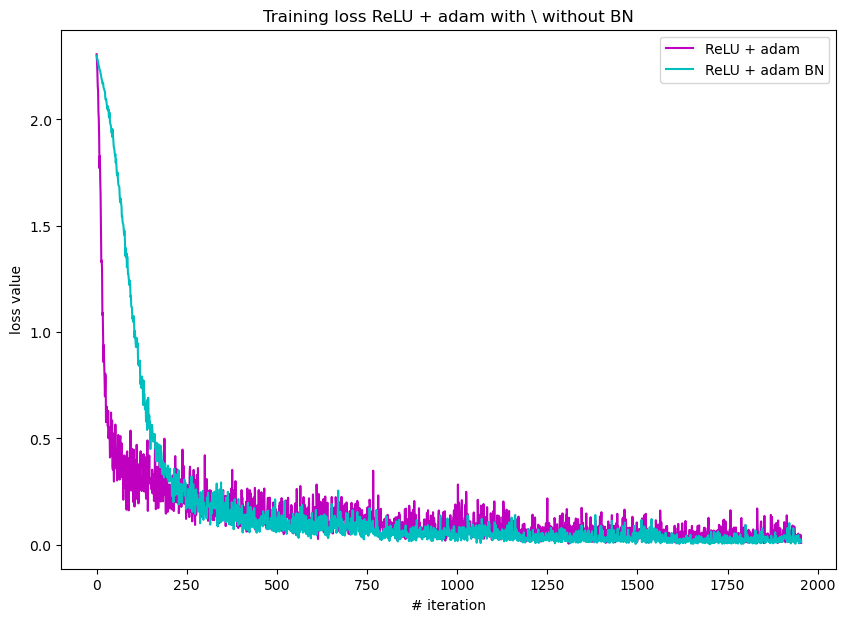

In [104]:
net_ReLU = net_creation(ReLU())
net_ReLU_bn = net_creation(ReLU(), batch_norm_flag= True)

optimizer_conf_adam = {'learning_rate': 0.001, 'beta1': 0.9, 'beta2': 0.999, 'epsilon': 1e-8}
# recommended default adam hyperparameters

iter_relu_loss_adam = loss_train_net(net_ReLU, X_train, y_train, adam_optimizer, optimizer_config=optimizer_conf_adam)
iter_relu_loss_bn_adam = loss_train_net(net_ReLU_bn, X_train, y_train, adam_optimizer, optimizer_config=optimizer_conf_adam)

visualisation_train_val(iter_relu_loss_adam, iter_relu_loss_bn_adam, 'ReLU + adam')

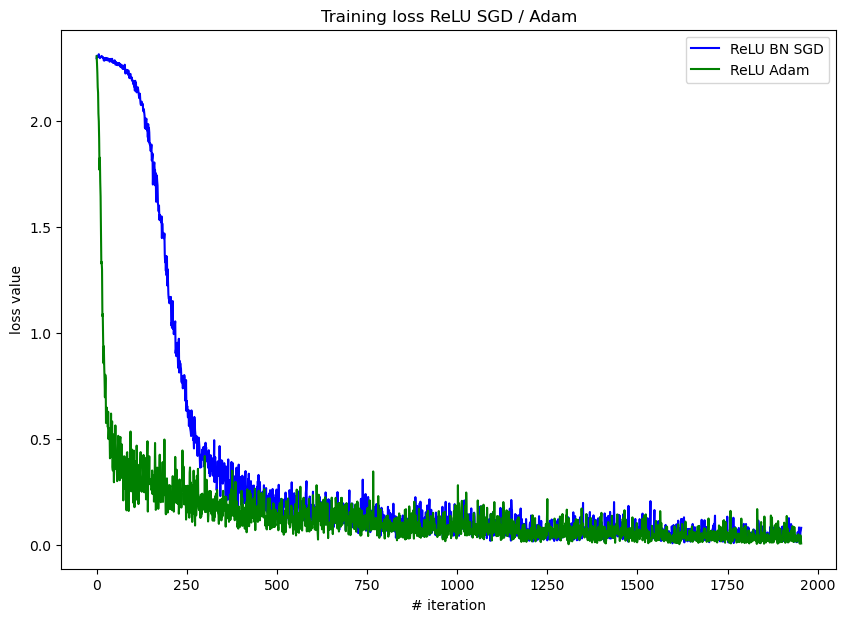

In [105]:
show_difference(iter_relu_loss_bn_sgd, iter_relu_loss_adam, 'ReLU')

## Net with ELU activation function
### SGD

Linear 784 -> 500
ELU
Linear 500 -> 100
ELU
Linear 100 -> 10
LogSoftMax

Linear 784 -> 324
BatchNormalization
ChannelwiseScaling
ELU
Linear 324 -> 100
BatchNormalization
ChannelwiseScaling
ELU
Linear 100 -> 10
LogSoftMax



100%|██████████| 5/5 [03:42<00:00, 44.44s/it]

Min loss value: 0.08285
Min loss value with BN: 0.0625


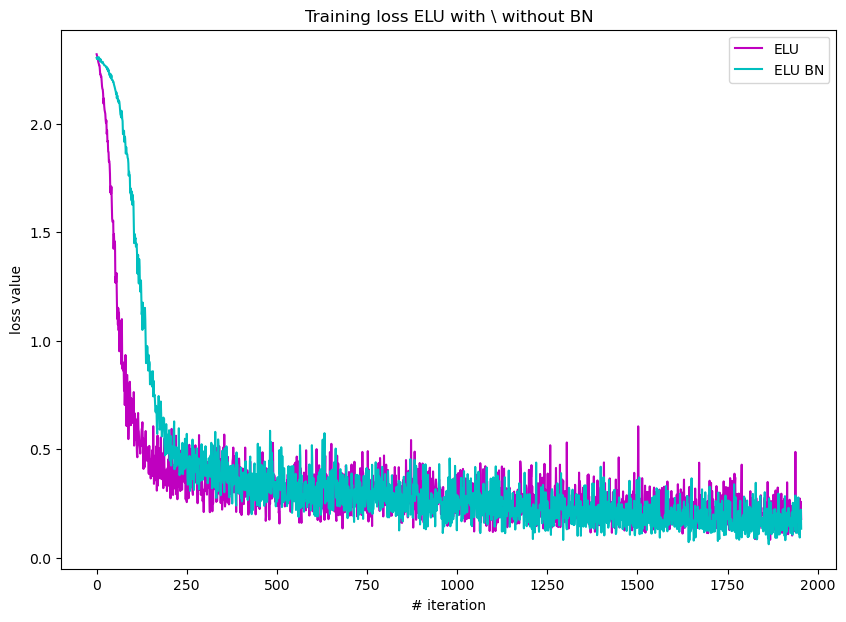

In [106]:
net_ELU = net_creation(ELU())
net_ELU_bn = net_creation(ELU(), batch_norm_flag= True)

iter_elu_loss_sgd = loss_train_net(net_ELU, X_train, y_train, sgd_momentum)
iter_elu_bn_loss_sgd = loss_train_net(net_ELU_bn, X_train, y_train, sgd_momentum)

visualisation_train_val(iter_elu_loss_sgd, iter_elu_bn_loss_sgd, 'ELU')

### Adam

Linear 784 -> 500
ELU
Linear 500 -> 100
ELU
Linear 100 -> 10
LogSoftMax

Linear 784 -> 324
BatchNormalization
ChannelwiseScaling
ELU
Linear 324 -> 100
BatchNormalization
ChannelwiseScaling
ELU
Linear 100 -> 10
LogSoftMax



100%|██████████| 5/5 [03:48<00:00, 45.68s/it]


Min loss value: 0.00965
Min loss value with BN: 0.05326


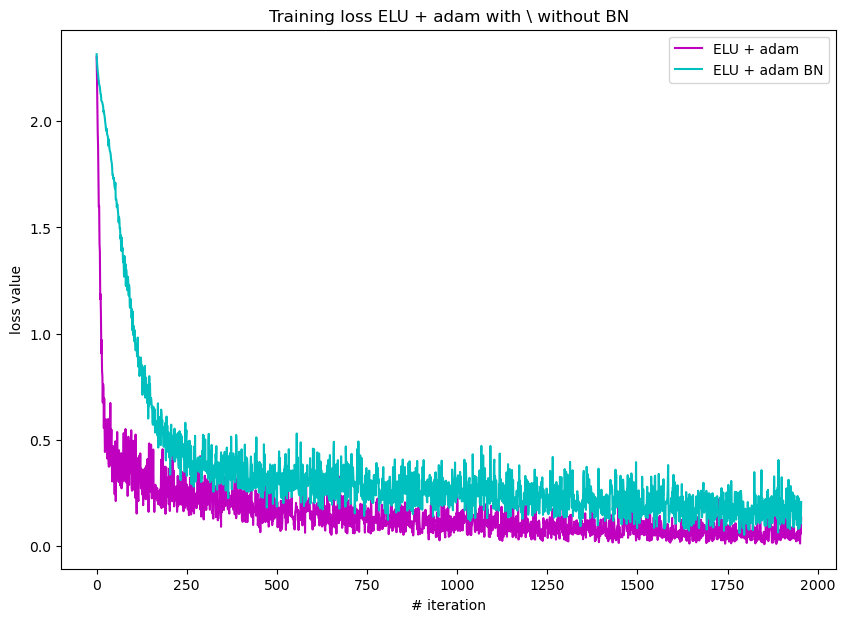

In [108]:
net_ELU = net_creation(ELU())
net_ELU_bn = net_creation(ELU(), batch_norm_flag= True)

optimizer_conf_adam = {'learning_rate': 0.001, 'beta1': 0.9, 'beta2': 0.999, 'epsilon': 1e-8}
iter_elu_loss_adam = loss_train_net(net_ELU, X_train, y_train, adam_optimizer, optimizer_config=optimizer_conf_adam)
iter_elu_bn_loss_adam = loss_train_net(net_ELU_bn, X_train, y_train, adam_optimizer, optimizer_config=optimizer_conf_adam)

visualisation_train_val(iter_elu_loss_adam, iter_elu_bn_loss_adam, 'ELU + adam')

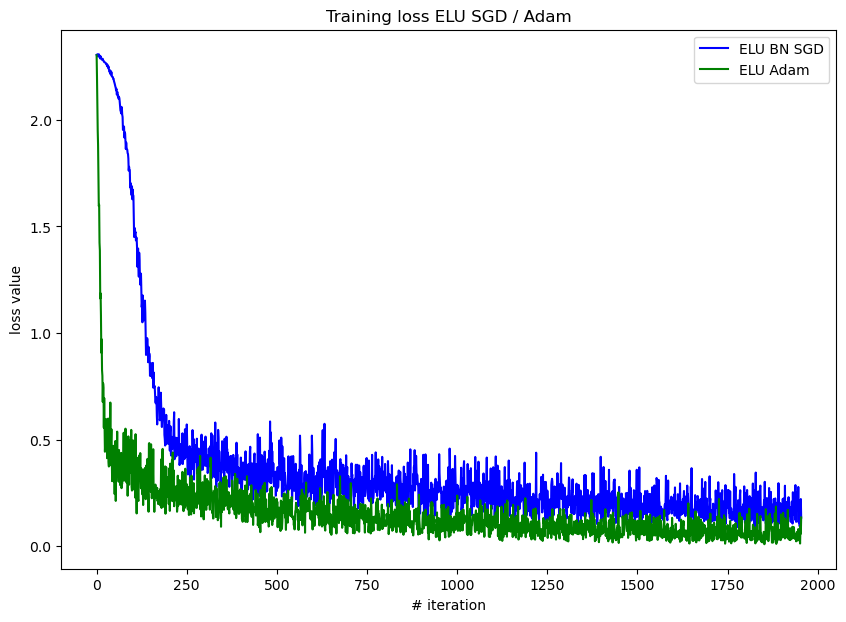

In [109]:
show_difference(iter_elu_bn_loss_sgd, iter_elu_loss_adam, 'ELU')

## Net with LeakyReLU activation function
### SGD

Linear 784 -> 500
LeakyReLU
Linear 500 -> 100
LeakyReLU
Linear 100 -> 10
LogSoftMax

Linear 784 -> 324
BatchNormalization
ChannelwiseScaling
LeakyReLU
Linear 324 -> 100
BatchNormalization
ChannelwiseScaling
LeakyReLU
Linear 100 -> 10
LogSoftMax



100%|██████████| 5/5 [03:27<00:00, 41.59s/it]


Min loss value: 0.05061
Min loss value with BN: 0.01017


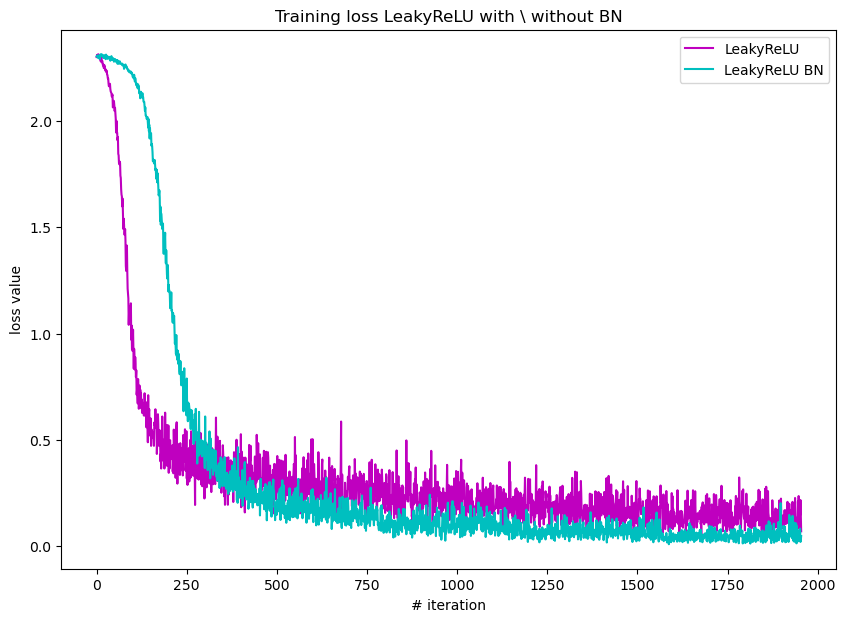

In [110]:
net_LeakyReLU = net_creation(LeakyReLU())
net_LeakyReLU_bn = net_creation(LeakyReLU(), batch_norm_flag= True)

iter_leakyRelu_loss_sgd = loss_train_net(net_LeakyReLU, X_train, y_train, sgd_momentum)
iter_leakyRelu_bn_loss_sgd = loss_train_net(net_LeakyReLU_bn, X_train, y_train, sgd_momentum)

visualisation_train_val(iter_leakyRelu_loss_sgd, iter_leakyRelu_bn_loss_sgd, 'LeakyReLU')

### Adam

Linear 784 -> 500
LeakyReLU
Linear 500 -> 100
LeakyReLU
Linear 100 -> 10
LogSoftMax

Linear 784 -> 324
BatchNormalization
ChannelwiseScaling
LeakyReLU
Linear 324 -> 100
BatchNormalization
ChannelwiseScaling
LeakyReLU
Linear 100 -> 10
LogSoftMax



100%|██████████| 5/5 [02:58<00:00, 35.61s/it]


Min loss value: 0.00555
Min loss value with BN: 0.00354


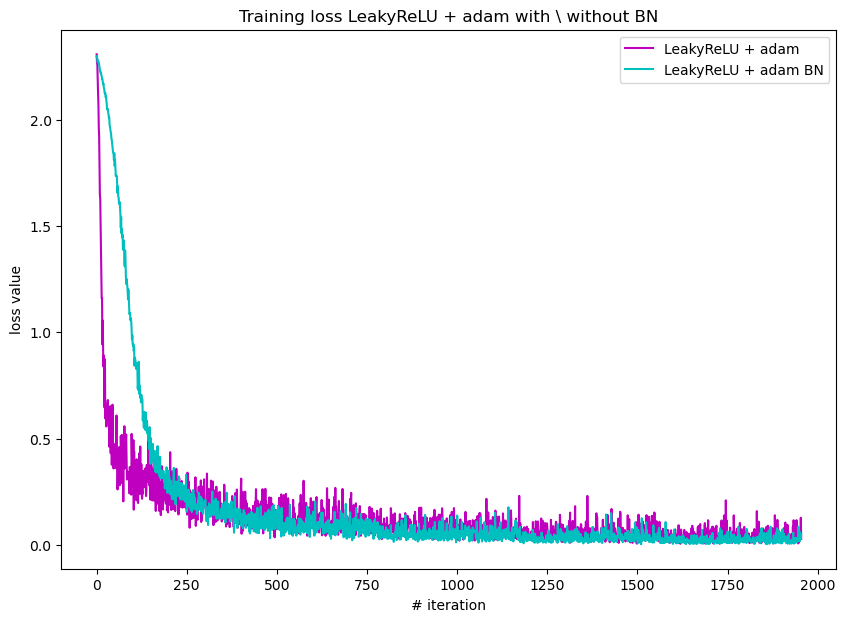

In [111]:
net_LeakyReLU = net_creation(LeakyReLU())
net_LeakyReLU_bn = net_creation(LeakyReLU(), batch_norm_flag= True)

optimizer_conf_adam = {'learning_rate': 0.001, 'beta1': 0.9, 'beta2': 0.999, 'epsilon': 1e-8}
iter_leakyRelu_loss_adam = loss_train_net(net_LeakyReLU, X_train, y_train, adam_optimizer, optimizer_config=optimizer_conf_adam)
iter_leakyRelu_bn_loss_adam = loss_train_net(net_LeakyReLU_bn, X_train, y_train, adam_optimizer, optimizer_config=optimizer_conf_adam)

visualisation_train_val(iter_leakyRelu_loss_adam, iter_leakyRelu_bn_loss_adam, 'LeakyReLU + adam')

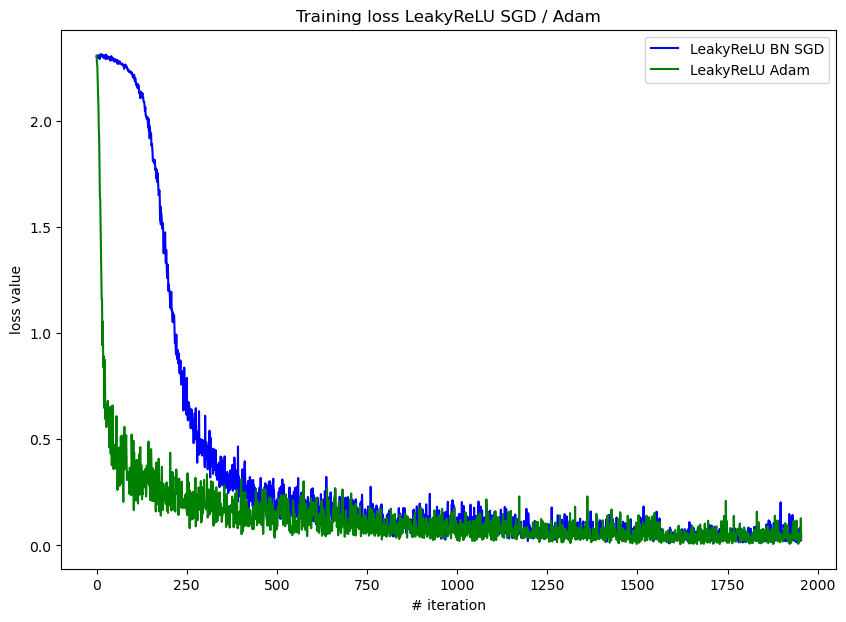

In [112]:
show_difference(iter_leakyRelu_bn_loss_sgd, iter_leakyRelu_loss_adam, 'LeakyReLU')

## Net with SoftPlus activation function

Linear 784 -> 500
SoftPlus
Linear 500 -> 100
SoftPlus
Linear 100 -> 10
LogSoftMax

Linear 784 -> 324
BatchNormalization
ChannelwiseScaling
SoftPlus
Linear 324 -> 100
BatchNormalization
ChannelwiseScaling
SoftPlus
Linear 100 -> 10
LogSoftMax



100%|██████████| 5/5 [02:52<00:00, 34.55s/it]

Min loss value: 0.11938
Min loss value with BN: 0.08672


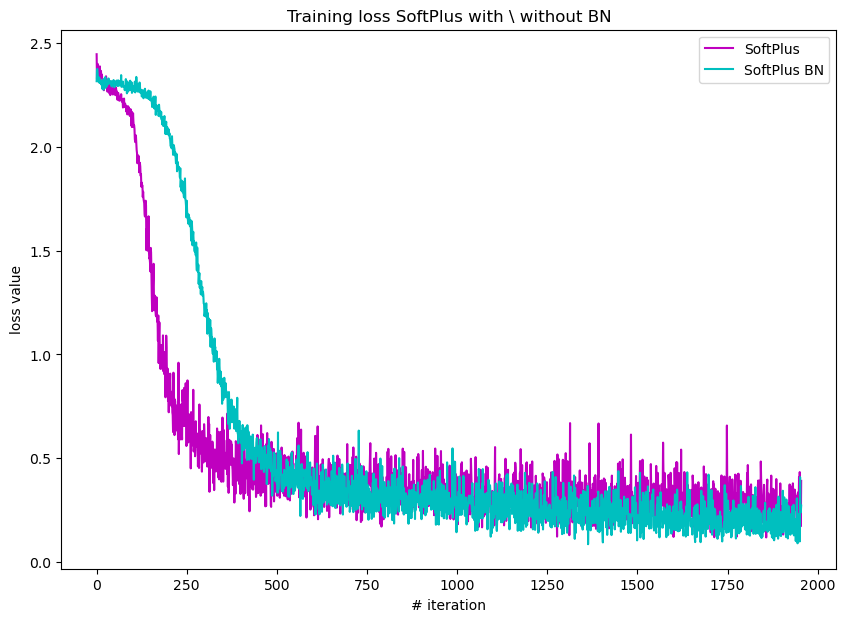

In [113]:
net_SoftPlus = net_creation(SoftPlus())
net_SoftPlus_bn = net_creation(SoftPlus(), batch_norm_flag= True)

iter_SoftPlus_loss_sgd = loss_train_net(net_SoftPlus, X_train, y_train, sgd_momentum)
iter_SoftPlus_bn_loss_sgd = loss_train_net(net_SoftPlus_bn, X_train, y_train, sgd_momentum)

visualisation_train_val(iter_SoftPlus_loss_sgd, iter_SoftPlus_bn_loss_sgd, 'SoftPlus')

Linear 784 -> 500
SoftPlus
Linear 500 -> 100
SoftPlus
Linear 100 -> 10
LogSoftMax

Linear 784 -> 324
BatchNormalization
ChannelwiseScaling
SoftPlus
Linear 324 -> 100
BatchNormalization
ChannelwiseScaling
SoftPlus
Linear 100 -> 10
LogSoftMax



100%|██████████| 5/5 [03:38<00:00, 43.62s/it]


Min loss value: 0.01475
Min loss value with BN: 0.08854


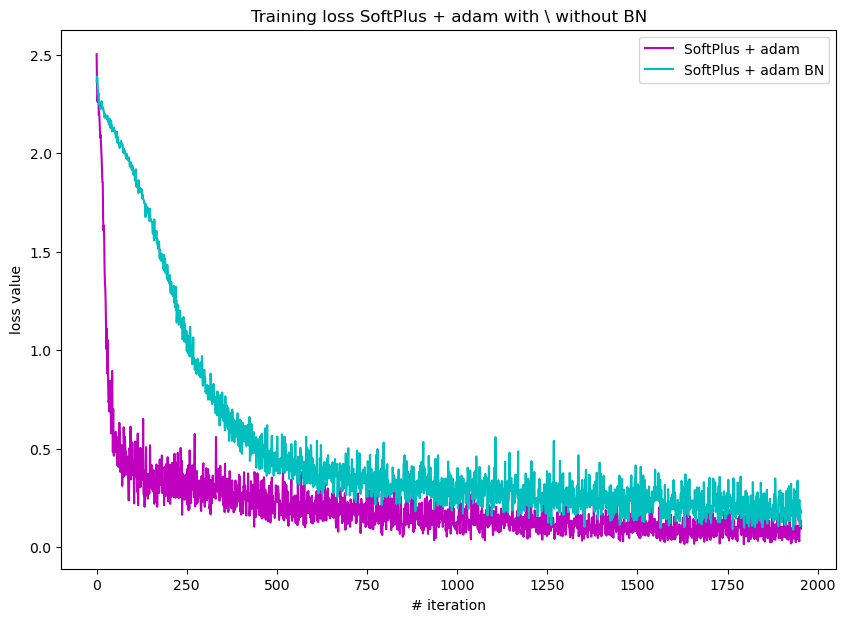

In [114]:
net_SoftPlus = net_creation(SoftPlus())
net_SoftPlus_bn = net_creation(SoftPlus(), batch_norm_flag= True)

optimizer_conf_adam = {'learning_rate': 0.001, 'beta1': 0.9, 'beta2': 0.999, 'epsilon': 1e-8}
iter_SoftPlus_loss_adam = loss_train_net(net_SoftPlus, X_train, y_train, adam_optimizer, optimizer_config=optimizer_conf_adam)
iter_SoftPlus_bn_loss_adam = loss_train_net(net_SoftPlus_bn, X_train, y_train, adam_optimizer, optimizer_config=optimizer_conf_adam)

visualisation_train_val(iter_SoftPlus_loss_adam, iter_SoftPlus_bn_loss_adam, 'SoftPlus + adam')

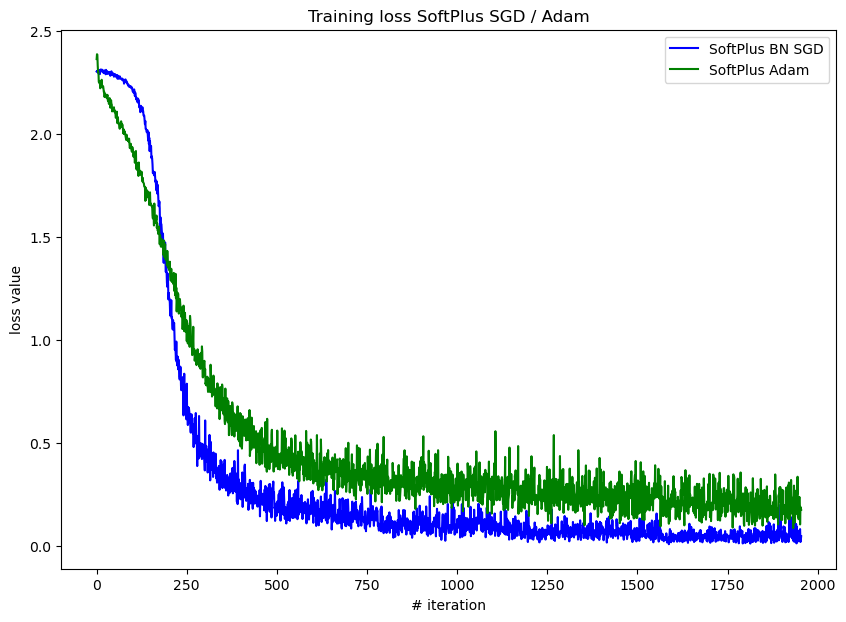

In [115]:
show_difference(iter_leakyRelu_bn_loss_sgd, iter_SoftPlus_bn_loss_adam, 'SoftPlus')

Write your personal opinion on the activation functions, think about computation times too. Does `BatchNormalization` help?

__Results:__
* There is an improvement after normalization: if the training time has not decreased, the final loss has decreased.<br> 
For example, for ReLU, which significantly confuses the data's average, a significant training acceleration and a decrease in loss are visible. <br>
In general, there is a trend, the more the activation function shifts the average, the more noticeable the improvement after normalization.
* As expected in theory, in practice in all cases (except Softmax) Adam converges faster than SGD. <br>
Usually it сonverges to better quality in same number of epochs.
* The models with ReLU and LeakyReLU activation functions showed the best quality. In combination with BN and Adam, they gave the smallest loss
---

**Finally**, use all your knowledge to build a super cool model on this dataset. Use **dropout** to prevent overfitting, play with **learning rate decay**. You can use **data augmentation** such as rotations, translations to boost your score. Use your knowledge and imagination to train a model. Don't forget to call `training()` and `evaluate()` methods to set desired behaviour of `BatchNormalization` and `Dropout` layers.

In [215]:
# Your code goes here. ################################################

def loss_train_net(net, X_train, Y_train, X_val, Y_val, optimizer, optimizer_config = optimizer_conf, batch_size = 128, n_epoch = 5, criterion = ClassNLLCriterion(), lr_decay_flag = True):
    
    epoch_train_loss_history = []
    iter_train_loss = []
    epoch_val_loss_history = []
    iter_val_loss = []
    optimizer_state = {}
    lr_0 = optimizer_conf['learning_rate']

    for i in tqdm(np.arange(n_epoch)):
        if lr_decay_flag:
            optimizer_config['learning_rate'] = lr_0 * (1/1+i)  # common way of lr decay

        net.train()
        train_temp_loss = []
        for x_batch, y_batch in get_batches((X_train, Y_train), batch_size):
            net.zeroGradParameters()
        
        # Forward
            predictions = net.forward(x_batch)
            loss = criterion.forward(predictions, y_batch)
    
        # Backward
            dp = criterion.backward(predictions, y_batch)
            net.backward(x_batch, dp)

        # Update weights
            optimizer(net.getParameters(), 
                         net.getGradParameters(), 
                         optimizer_config,
                         optimizer_state)      
        
            train_temp_loss.append(loss)
            iter_train_loss.append(loss)

        epoch_train_loss_history.append(np.mean(train_temp_loss))
        
        net.evaluate()
        val_temp_loss = []
        for x_batch, y_batch in get_batches((X_val, Y_val), batch_size):
            predictions = net.forward(x_batch)
            loss = criterion.forward(predictions, y_batch)
        
            val_temp_loss.append(loss)
            iter_val_loss.append(loss)

        epoch_val_loss_history.append(np.mean(loss))

        print(f'Epoch #{i+1} / {n_epoch}')
        print(f'train loss: {np.round(epoch_train_loss_history[-1], 5)}')
        print(f'val loss: {np.round(epoch_val_loss_history[-1], 5)}')
    
    return epoch_train_loss_history, epoch_val_loss_history, iter_train_loss, iter_val_loss


In [175]:
super_net = Sequential()
super_net.add(Linear(784, 324))  
super_net.add(BatchNormalization())
super_net.add(ChannelwiseScaling(324))
super_net.add(ReLU())
super_net.add(Linear(324, 100)) 
super_net.add(BatchNormalization())
super_net.add(ChannelwiseScaling(100))
super_net.add(ReLU())  
super_net.add(Dropout())
super_net.add(Linear(100, n_classes))
super_net.add(LogSoftMax())



optimizer_conf_adam = {'learning_rate': 0.01, 'beta1': 0.9, 'beta2': 0.999, 'epsilon': 1e-8}
epoch_train_loss_super_net_adam, epoch_val_loss_super_net_adam, iter_train_loss_super_net_adam, iter_val_loss_super_net_adam = loss_train_net(super_net, X_train, y_train, X_val, y_val, optimizer = adam_optimizer, optimizer_config = optimizer_conf_adam, n_epoch=10)
    

 10%|█         | 1/10 [00:43<06:27, 43.02s/it]

Epoch #1 / 10
train loss: 0.33715
val loss: 0.57605


 20%|██        | 2/10 [01:28<05:55, 44.46s/it]

Epoch #2 / 10
train loss: 0.17681
val loss: 0.01773


 30%|███       | 3/10 [02:14<05:17, 45.37s/it]

Epoch #3 / 10
train loss: 0.16029
val loss: 0.01796


 40%|████      | 4/10 [03:00<04:33, 45.55s/it]

Epoch #4 / 10
train loss: 0.15772
val loss: 0.00079


 50%|█████     | 5/10 [03:45<03:46, 45.29s/it]

Epoch #5 / 10
train loss: 0.17804
val loss: 0.39957


 60%|██████    | 6/10 [04:31<03:01, 45.42s/it]

Epoch #6 / 10
train loss: 0.1857
val loss: 0.03979


 70%|███████   | 7/10 [05:17<02:16, 45.64s/it]

Epoch #7 / 10
train loss: 0.19696
val loss: 0.40731


 80%|████████  | 8/10 [06:05<01:32, 46.37s/it]

Epoch #8 / 10
train loss: 0.2166
val loss: 0.19321


 90%|█████████ | 9/10 [06:49<00:45, 45.55s/it]

Epoch #9 / 10
train loss: 0.24393
val loss: 0.00328


100%|██████████| 10/10 [07:33<00:00, 45.39s/it]

Epoch #10 / 10
train loss: 0.22036
val loss: 0.03465


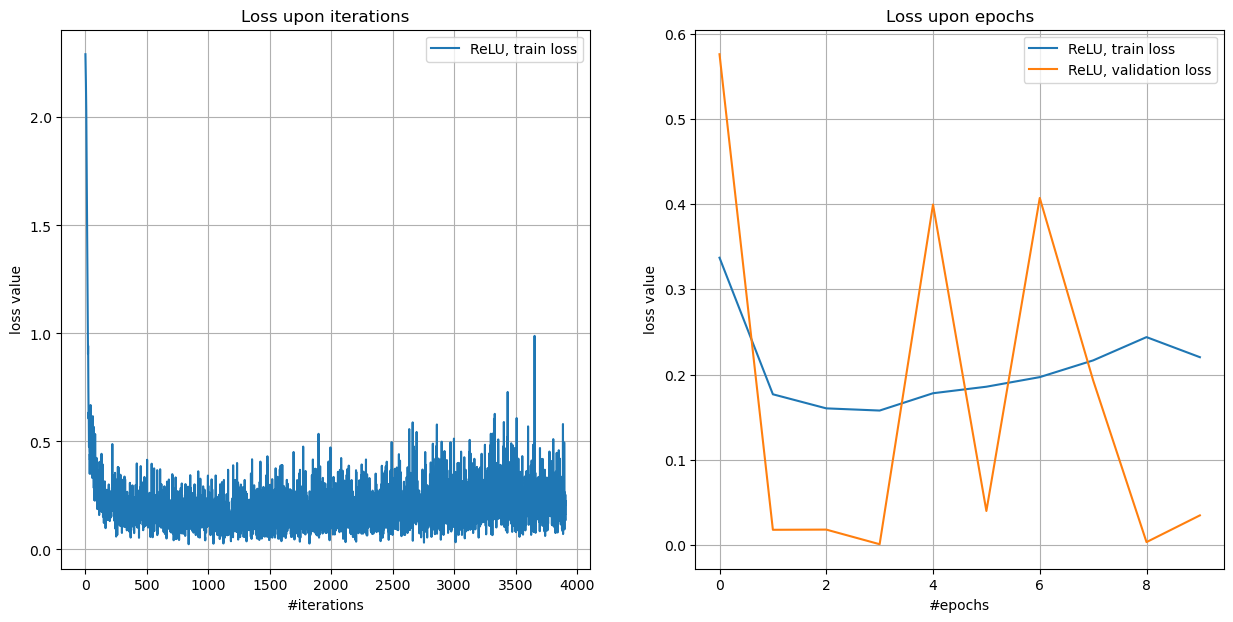

In [184]:
plt.figure(figsize=(15,7))

loss_data = [[iter_train_loss_super_net_adam, iter_val_loss_super_net_adam], [epoch_train_loss_super_net_adam, epoch_val_loss_super_net_adam]]
axes_x = [['iterations','train'], ['epochs', 'validation']]
for i in range(2):
        ax = plt.subplot(1, 2, i+1)
        ax.plot(loss_data[i][0], label = 'ReLU, '+ axes_x[0][1] + ' loss')
        if i:
                ax.plot(loss_data[i][1], label = 'ReLU, '+ axes_x[1][1] + ' loss')
        ax.grid(which = 'major')
        ax.set_xlabel('#' + axes_x[i][0])
        ax.set_ylabel('loss value')
        ax.set_title('Loss upon ' + axes_x[i][0])
        ax.legend()

plt.show()

Print here your accuracy on test set. It should be around 90%.

In [181]:
# Your answer goes here. ################################################

super_net.evaluate()
y_predictions = np.array([])
y_label = np.array([])

for X_batch, Y_batch in get_batches((X_test, y_test), 128):

    predictions = super_net.forward(X_batch)
    y_predictions = np.concatenate((y_predictions, predictions.argmax(axis=1)))
    y_label = np.concatenate((y_label, Y_batch.argmax(axis=1)))

print(f"Accuracy on test set: {np.round(np.mean(y_label == y_predictions),5)}")

Accuracy on test set: 0.9614


**So, that's nice result, even if validation figure looks weird. Guess, this happened because the validation data is few** <br>
Below I will implement the model without reducing the learning rate, this is needed for a more objective comparison of the quality of the two models

 10%|█         | 1/10 [00:45<06:45, 45.01s/it]

Epoch #1 / 10
train loss: 0.82298
val loss: 0.11726


 20%|██        | 2/10 [01:28<05:51, 43.96s/it]

Epoch #2 / 10
train loss: 0.1504
val loss: 0.24914


 30%|███       | 3/10 [02:10<05:02, 43.20s/it]

Epoch #3 / 10
train loss: 0.09568
val loss: 0.00206


 40%|████      | 4/10 [02:55<04:23, 43.95s/it]

Epoch #4 / 10
train loss: 0.07168
val loss: 0.00523


 50%|█████     | 5/10 [03:36<03:34, 42.83s/it]

Epoch #5 / 10
train loss: 0.05553
val loss: 0.00657


 60%|██████    | 6/10 [04:17<02:49, 42.36s/it]

Epoch #6 / 10
train loss: 0.04672
val loss: 0.05784


 70%|███████   | 7/10 [05:02<02:09, 43.13s/it]

Epoch #7 / 10
train loss: 0.04015
val loss: 0.07647


 80%|████████  | 8/10 [05:46<01:26, 43.41s/it]

Epoch #8 / 10
train loss: 0.035
val loss: 0.00072


 90%|█████████ | 9/10 [06:31<00:43, 43.87s/it]

Epoch #9 / 10
train loss: 0.02713
val loss: 0.00093


100%|██████████| 10/10 [07:14<00:00, 43.42s/it]

Epoch #10 / 10
train loss: 0.02634
val loss: 0.43889


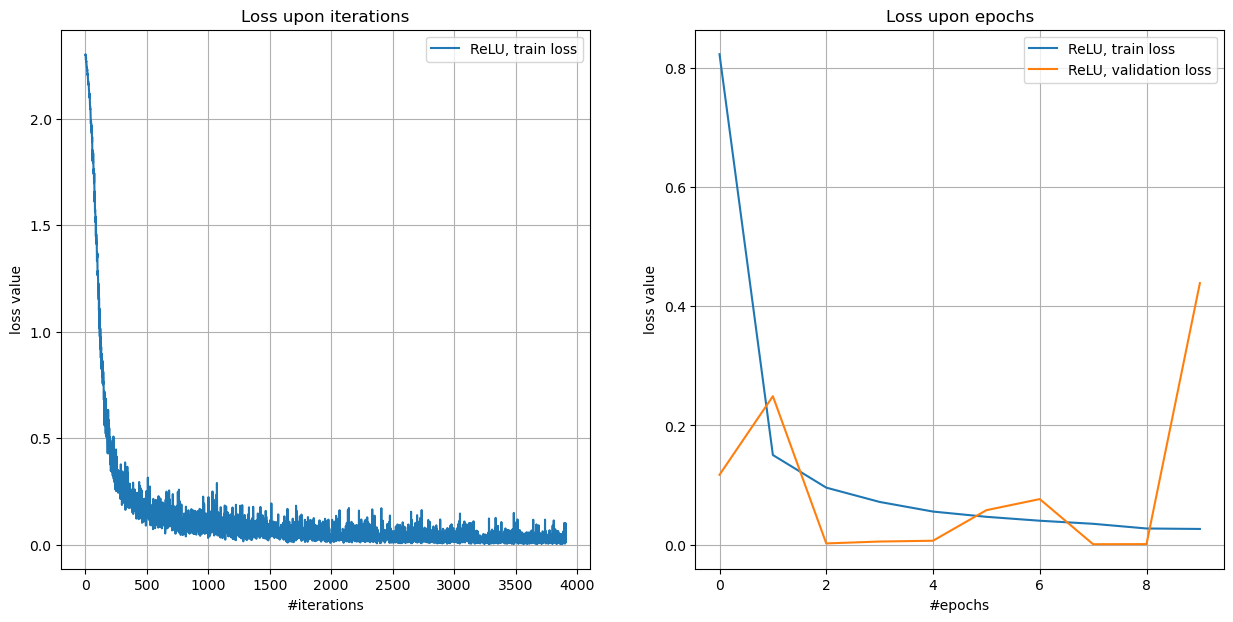

In [217]:
super_net = Sequential()
super_net.add(Linear(784, 324))  
super_net.add(BatchNormalization())
super_net.add(ChannelwiseScaling(324))
super_net.add(ReLU())
super_net.add(Linear(324, 100)) 
super_net.add(BatchNormalization())
super_net.add(ChannelwiseScaling(100))
super_net.add(ReLU())  
super_net.add(Dropout())
super_net.add(Linear(100, n_classes))
super_net.add(LogSoftMax())



optimizer_conf_adam = {'learning_rate': 0.001, 'beta1': 0.9, 'beta2': 0.999, 'epsilon': 1e-8}
epoch_train_loss_super_net_adam, epoch_val_loss_super_net_adam, iter_train_loss_super_net_adam, iter_val_loss_super_net_adam = loss_train_net(super_net, X_train, y_train, X_val, y_val, optimizer = adam_optimizer, optimizer_config = optimizer_conf_adam, n_epoch=10, lr_decay_flag=False)

plt.figure(figsize=(15,7))

loss_data = [[iter_train_loss_super_net_adam, iter_val_loss_super_net_adam], [epoch_train_loss_super_net_adam, epoch_val_loss_super_net_adam]]
axes_x = [['iterations','train'], ['epochs', 'validation']]
for i in range(2):
        ax = plt.subplot(1, 2, i+1)
        ax.plot(loss_data[i][0], label = 'ReLU, '+ axes_x[0][1] + ' loss')
        if i:
                ax.plot(loss_data[i][1], label = 'ReLU, '+ axes_x[1][1] + ' loss')
        ax.grid(which = 'major')
        ax.set_xlabel('#' + axes_x[i][0])
        ax.set_ylabel('loss value')
        ax.set_title('Loss upon ' + axes_x[i][0])
        ax.legend()

plt.show()
    

In [221]:
super_net.evaluate()
y_predictions = np.array([])
y_label = np.array([])

for X_batch, Y_batch in get_batches((X_test, y_test), 128):

    predictions = super_net.forward(X_batch)
    y_predictions = np.concatenate((y_predictions, predictions.argmax(axis=1)))
    y_label = np.concatenate((y_label, Y_batch.argmax(axis=1)))

print(f"Accuracy on test set: {np.round(np.mean(y_label == y_predictions),5)}")

Accuracy on test set: 0.98


### Comparing with PyTorch implementation
The last (and maybe the easiest step after compared to the previous tasks: build a network with the same architecture as above now with PyTorch.

You can refer to the `week0_09` or `Lab3_part2` notebooks for hints.

__Good Luck!__

In [173]:
import torch, torch.nn as nn
import torchsummary

In [200]:
# Your beautiful code here.

def train_model(net,X_train, Y_train, X_val, Y_val, loss_fn, optimizer, n_epochs):
    train_loss = []
    val_loss = []
    val_accuracy = []

    for epoch in range(n_epochs):
        ep_train_loss = []
        ep_val_loss = []
        ep_val_accuracy = []

        net.train()
        for x_batch, y_batch in get_batches((X_train, Y_train), batch_size):
            optimizer.zero_grad()

            x_batch = torch.Tensor(x_batch)
            y_batch = torch.Tensor(y_batch)

            predictions = net(x_batch)
            loss = loss_fn(predictions, y_batch)
            loss.backward()

            optimizer.step()

            ep_train_loss.append(loss.item())
        
        net.train(False)
        with torch.no_grad():
            for x_batch, y_batch in get_batches((X_val, Y_val), batch_size):
                x_batch = torch.Tensor(x_batch)
                y_batch = torch.Tensor(y_batch)

                predictions = net(x_batch)
                loss = loss_fn(predictions, y_batch)
                ep_val_loss.append(loss.item())

                y_pred = predictions.argmax(axis = 1)
                ep_val_accuracy.append(np.mean((y_pred == y_batch.argmax(axis=1)).numpy()))
        
        train_loss.append(np.mean(ep_train_loss))
        val_loss.append(np.mean(ep_val_loss))
        val_accuracy.append(np.mean(ep_val_accuracy))
        
        print(f'Epoch #{epoch+1} / {n_epochs}')
        print(f'train loss: {np.round(train_loss[-1], 5)}')
        print(f'validation loss: {np.round(val_loss[-1], 5)}')
        print(f'validation accuracy: {np.round(val_accuracy[-1], 5)}', '\n')

    return train_loss, val_loss, val_accuracy


In [218]:
torch_net = nn.Sequential(
    nn.Linear(784, 324),
    nn.BatchNorm1d(324),
    nn.ReLU(),
    nn.Linear(324, 100),
    nn.BatchNorm1d(100),
    nn.ReLU(),
    nn.Linear(100,n_classes)    
)


loss_func = nn.CrossEntropyLoss()
optim = torch.optim.Adam(torch_net.parameters(), lr = 0.001)    

train_loss, val_loss, val_accuracy = train_model(torch_net, X_train, y_train, X_val, y_val, loss_fn =loss_func, optimizer = optim, n_epochs = 10)

Epoch #1 / 10
train loss: 0.2567
validation loss: 0.1014
validation accuracy: 0.97142 

Epoch #2 / 10
train loss: 0.08378
validation loss: 0.08431
validation accuracy: 0.9734 

Epoch #3 / 10
train loss: 0.05275
validation loss: 0.0815
validation accuracy: 0.97666 

Epoch #4 / 10
train loss: 0.03719
validation loss: 0.07349
validation accuracy: 0.97676 

Epoch #5 / 10
train loss: 0.02717
validation loss: 0.06795
validation accuracy: 0.97923 

Epoch #6 / 10
train loss: 0.02237
validation loss: 0.07493
validation accuracy: 0.97884 

Epoch #7 / 10
train loss: 0.01875
validation loss: 0.08468
validation accuracy: 0.97716 

Epoch #8 / 10
train loss: 0.0161
validation loss: 0.08068
validation accuracy: 0.97656 

Epoch #9 / 10
train loss: 0.01326
validation loss: 0.07678
validation accuracy: 0.98081 

Epoch #10 / 10
train loss: 0.01137
validation loss: 0.08582
validation accuracy: 0.97686 



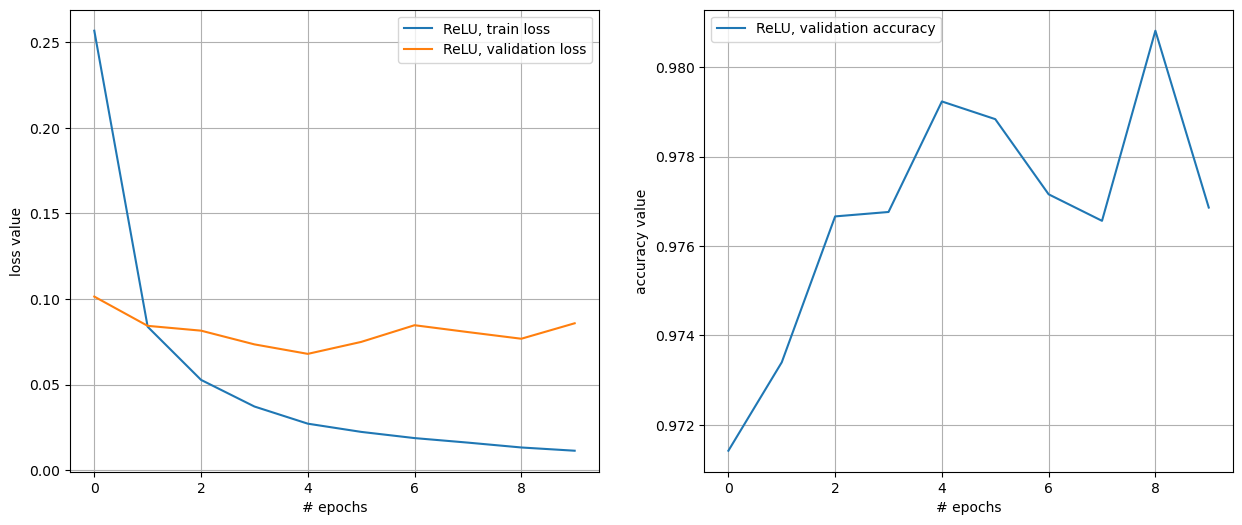

In [219]:
plt.figure(figsize=(15,6))

net_data = [[train_loss, val_loss], val_accuracy]
titles = ['loss', 'accuracy']
for i in range(2):
        ax = plt.subplot(1, 2, i+1)
        
        if not i:
                ax.plot(net_data[i][0], label = 'ReLU, train loss')
                ax.plot(net_data[i][1], label = 'ReLU, validation loss')
                ax.set_ylabel('loss value')
        else:
                ax.plot(net_data[i], label = 'ReLU, validation accuracy')
                ax.set_ylabel('accuracy value')

        ax.grid(which = 'major')
        ax.set_xlabel('# epochs')
        ax.legend()

plt.show()

In [220]:
torch_net.train(False)
y_predictions = np.array([])
y_label = np.array([])
with torch.no_grad():
    for x_batch, y_batch in get_batches((X_test, y_test), 128):
        x_batch = torch.Tensor(x_batch)
        y_batch = torch.Tensor(y_batch)

        predictions = torch_net(x_batch).numpy()
        y_predictions = np.concatenate((y_predictions, predictions.argmax(axis=1)))
        y_label = np.concatenate((y_label, y_batch.argmax(axis=1)))

print(f"Accuracy on test set: {np.round(np.mean(y_label == y_predictions),5)}")

Accuracy on test set: 0.9775


**Results:**
* As we can see self-made net's accuracy and torch net's are very close. Means everything done well
* Torch's net trains much faster